# Uvod

Klasifikacija planeta i satelita Sunčevog sistema, čime će se baviti ovaj projekat, je zadatak koji nalazi svoju primenu u oblastima astronomije i istraživanja svemira. Cilj projekta je da se, koristeći napredne tehnike obrade slika i mašinskog učenja, predstavi model koji će biti sposoban da prepozna i razlikuje prvo planete, a zatim i njihove prirodne satelite na osnovu njihovih fotografija.  

Isti model će biti primenjen za obe klasifikacije. 

## Planete

Sunčev sistem se sastoji od 8 planeta, koji ujedno predstavljaju i klase koje će model predviđati:  
Merkur, Venera, Zemlja, Mars, Jupiter, Saturn, Uran i Neptun.  

Baza slika korišćena za njihovu klasifikaciju može se pronaći na sledećem linku:  
https://www.kaggle.com/datasets/emirhanai/planets-and-moons-dataset-ai-in-space?resource=download

Svaka planeta ima oko 150 fotografija, što čini osnovni skup za dalju analizu. 

U ovom delu projekta, biće prikazana dva načina za učitavanje lične baze podataka, jedan preko keras.utils biblioteke, a drugi preko klase ImageDataGenerator.  
Razlika između ova dva pristupa je što prvi učitava neizmenjene slike, dok korišćenje drugog podrazumeva proširenje gotovog skupa podataka preko augmentacije slika koristeći nasumično uvećanje, rotiranje, sečenje i okretanje fotografija, što doprinosi većoj raznolikosti podataka i povećanje sposobnosti generalizacije modela. 

##### Učitavanje potrebnih biblioteka

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

2024-05-07 16:07:27.381998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 16:07:27.414508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 16:07:27.414534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 16:07:27.415486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 16:07:27.420388: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 16:07:27.420842: I tensorflow/core/platform/cpu_feature_guard.cc:1

##### Deklaracija korenog direktorijuma i klasa

In [2]:
data_dir = pathlib.Path('planete')
planete = ['Merkur', 'Venera', 'Zemlja', 'Mars', 'Jupiter', 'Saturn', 'Uran', 'Neptun']

##### Parametri za konvolutivne mreže

Bitni parametri za treniranje modela su broj uzoraka po grupi (batch size) i veličina slike.  
Broj uzoraka po grupi je broj slika koji će se koristiti u jednoj iteraciji treniranja modela. Veći batch_size može ubrzati proces učenja, ali i zauzeti više memorije, dok manji može pružiti stabilniji proces učenja.  
Što se tiče veličine slike, konvolutivne mreže očekuju ulazne slike fiksne veličine, jer su dizajnirani da obrađuju matrice piksela određenih dimenzija. Postavljanjem visine i širine slike, definišu se dimenzije ulaznih slika koje će se koristiti za treniranje. Ove dimenzije moraju odgovarati ulaznom sloju modela.

In [3]:
batch_size = 32
visina_slike = 256
sirina_slike = 256

#### Učitavanje pomoću keras.utils biblioteke

Korišćenjem funkcije **tf.keras.utils.image_dataset_from_directory** neće se izvršiti nikakve izmene nad skupom podataka. Ona jednostavno učitava slike i kreira skup podataka koji se može koristiti za treniranje, testiranje i validaciju modela.  
Jedini vid preprocesiranja je normalizacija vrednosti piksela - prebacivanje na opseg vrednosti [0,1] - što znači da će gradijenti koji se koriste za ažuriranje težina biti manji i stabilniji, što može dovesti do bržeg i stabilnijeg učenja.

U tensorflow dokumentaciji (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) se može naći argumenti koje prima ova funkcija, od kojih su bitniji:
- directory - direktorijum u kom se nalaze slike
- class_names - eksplicitna lista imena klasa. Ukoliko se ne navede, imena klasa odgovaraju imenima poddirektorijuma
- batch_size - broj uzoraka po grupi
- image_size - veličina slike
- validation_split - mora biti jednak za trening i validacioni skup. Govori koji procenat podataka se čuva za validacioni skup
- subset - podskup podataka koji vraća funkcija. Može uzimati vrednost 'training', 'validation' ili 'both'.
- seed - opciono 'seme' za nasumično mešanje podataka. Koristi se da bi se osiguralo da se pri svakom pokretanju programa podaci mešaju na isti način. Mora biti isti za trening i validacioni skup.

Može se primetiti da ovaj vid učitavanja podataka ne daje test skup, već samo validacioni.  
Ovo se može prevazići tako što se izvrši dalja podela validacionog skupa - na primer, 10% za validaciju i 20% za test. 

In [4]:
# Skup podataka za treniranje
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(visina_slike, sirina_slike),
  batch_size=batch_size)

# Skup podataka za validaciju
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(visina_slike, sirina_slike),
  batch_size=batch_size)

# Normalizacija
norm = tf.keras.layers.Rescaling(1./255)



Found 1192 files belonging to 8 classes.
Using 835 files for training.
Found 1192 files belonging to 8 classes.
Using 357 files for validation.


2024-05-07 16:07:33.277858: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Sada treba odrediti koliko je gomila dostupno u validacionom skupu koristeći funkciju **tf.data.experimental.cardinality** i iskoristiti dve trećine za test skup pomoću funkcija take() i skip()

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Provera imena klasa preko polja class_names:

In [6]:
num_images_test = tf.data.experimental.cardinality(test_ds)
num_images_val = tf.data.experimental.cardinality(val_ds)
print(f"Broj slika u test_ds: {num_images_test}")
print(f"Broj slika u val_ds: {num_images_val}")

Broj slika u test_ds: 8
Broj slika u val_ds: 4


In [7]:
imena_klasa = train_ds.class_names
print(imena_klasa)

['Jupiter', 'Mars', 'Merkur', 'Neptun', 'Saturn', 'Uran', 'Venera', 'Zemlja']


### Model za klasifikaciju

Model preuzet od: Emirhan Bulut **https://www.linkedin.com/in/artificialintelligencebulut/**

Opis arhitekture modela:

- Conv2D slojevi: Ovi slojevi predstavljaju konvolutivne slojeve koji koriste filtere za izdvajanje karakteristika iz slika. U ovom modelu, postoje tri Conv2D sloja sa 128, 256 i 512 filtera, redom. Svaki filter prolazi kroz ulaznu sliku koristeći određeni korak (*strides*) i izračunava konvoluciju.
- BatchNormalization: Ovaj sloj se koristi za normalizaciju izlaza prethodnog sloja. To pomaže u stabilizaciji procesa učenja i ubrzava konvergenciju mreže.
- SpatialDropout slojevi: Ovi slojevi primenjuju dropout na ulaznom sloju, gde se nasumično određeni neuroni isključuju tokom treninga sa određenom verovatnoćom (u ovom slučaju 20%). Ovo pomaže u prevenciji prenaučenosti i poboljšava generalizaciju modela.
- MaxPooling2D slojevi: Ovi slojevi primenjuju max pooling operaciju na izlazima prethodnih slojeva kako bi se smanjila dimenzionalnost i izdvojile ključne osobine iz slike.
- Flatten sloj: Ovaj sloj se koristi za ravnanje (*flatten*) izlaza iz poslednjeg sloja konvolucije u vektor koji će biti ulaz u potpuno povezane (*dense*) slojeve.
- Dense slojevi: Ovi slojevi su potpuno povezani i koriste se za klasifikaciju izlaza iz prethodnih slojeva. U ovom modelu, postoji jedan Dense sloj sa 128 neurona i jedan sa 11 neurona (jedan za svaku klasu), koji koristi softmax aktivaciju za generisanje verovatnoća svake klase.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, SpatialDropout2D

model = Sequential([
    Conv2D(128, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True, input_shape=(256, 256, 3)),
    BatchNormalization(),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Conv2D(256, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Conv2D(512, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(11, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


*Sparse categorical crossentropy* je funkcija gubitka koja se koristi za višeklasnu klasifikaciju kada su oznake ciljne klase predstavljene kao celobrojne vrednosti (npr. 0, 1, 2, ...) umesto one-hot kodiranja. Računa gubitak između predviđenih verovatnoća klasa i stvarnih oznaka ciljnih klasa, uzimajući u obzir samo indeks ciljne klase za svaki podatak.

### Treniranje i evaluacija modela

U ovom primeru, EarlyStopping će pratiti gubitak (*loss*) na validacionom skupu (*monitor='val_loss'*) i zaustaviti trening ako se gubitak ne smanji tokom 3 uzastopne epohe (*patience=3*). Parametar *restore_best_weights=True* će vratiti težine modela na one koje su dale najbolje rezultate na validacionom skupu.

Epoch 1/10
27/27 [==============================] - 38s 1s/step - loss: 2.5725 - accuracy: 0.6000 - val_loss: 0.6346 - val_accuracy: 0.7822
Epoch 2/10
27/27 [==============================] - 40s 1s/step - loss: 0.0649 - accuracy: 0.9868 - val_loss: 0.3241 - val_accuracy: 0.8812
Epoch 3/10
27/27 [==============================] - 42s 2s/step - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.1284 - val_accuracy: 0.9703
Epoch 4/10
27/27 [==============================] - 40s 1s/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.1292 - val_accuracy: 0.9802
Epoch 5/10
27/27 [==============================] - 42s 2s/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.1690 - val_accuracy: 0.9307
Epoch 6/10
27/27 [==============================] - 40s 1s/step - loss: 0.0101 - accuracy: 0.9976 - val_loss: 0.0485 - val_accuracy: 1.0000
Epoch 7/10
27/27 [==============================] - 49s 2s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 8/10
27/27 [==

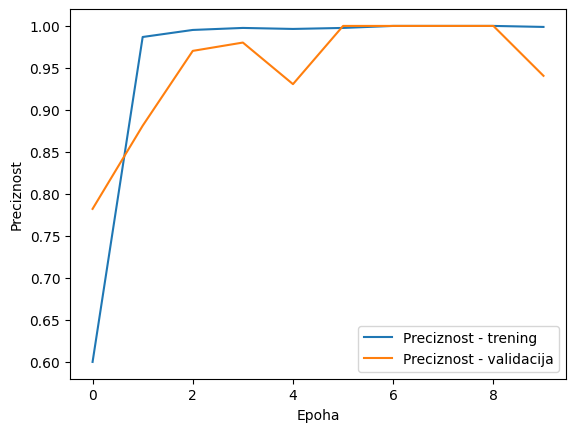

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Definisanje EarlyStopping callback-a
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treniranje modela sa EarlyStopping callback-om
history = model.fit(train_ds,validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Prikazivanje grafika tačnosti
plt.plot(history.history['accuracy'], label='Preciznost - trening')
plt.plot(history.history['val_accuracy'], label='Preciznost - validacija')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()
plt.show()



Model pokazuje izuzetne performanse.

### Upotreba modela u klasifikaciji planeta

8/8 [==============================] - 2s 238ms/step


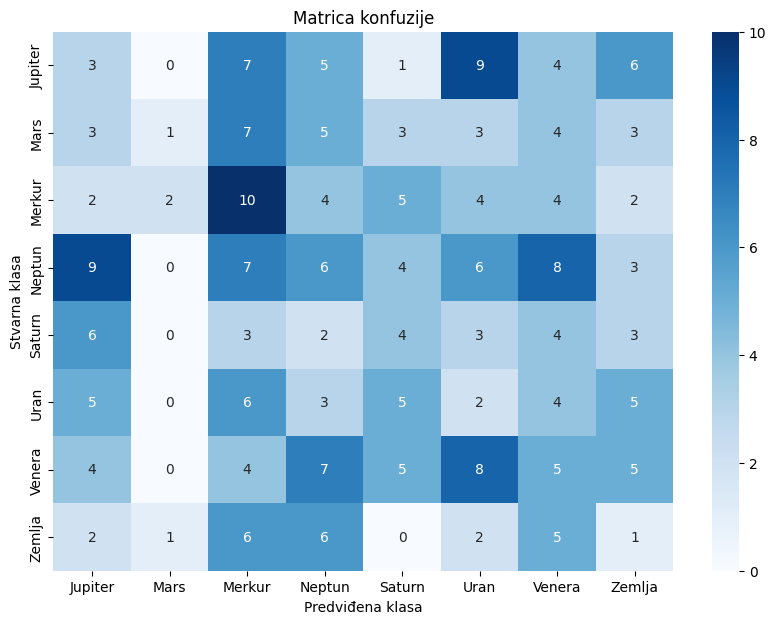

8/8 [==============================] - 2s 240ms/step - loss: 0.1991 - accuracy: 0.8984
Preciznost na test skupu: 0.8984375
Gubitak na test skupu: 0.19908398389816284


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predviđanja modela za test skup
predikcije = np.argmax(model.predict(test_ds), axis=-1)

# Stvarne vrednosti za test skup
stvarno = np.concatenate([y for x, y in test_ds], axis=0)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Definisanje imena klasa
imena_klasa = ['Jupiter', 'Mars', 'Merkur', 'Neptun', 'Saturn', 'Uran', 'Venera', 'Zemlja']

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=imena_klasa, columns=imena_klasa)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()


# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(test_ds)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

### Predikcije modela na test skupu

In [11]:
import os

direktorijum = "planete"

putanje_slika = []
for koren, direktorijumi, fajlovi in os.walk(direktorijum):
    for fajl in fajlovi:
        if fajl.endswith(".jpg"):  # ili bilo koji drugi format slika koji koristite
            putanja = os.path.join(koren, fajl)
            putanje_slika.append(putanja)

print(putanje_slika)


['planete/Saturn/Saturn (53).jpg', 'planete/Saturn/Saturn (74).jpg', 'planete/Saturn/Saturn (108).jpg', 'planete/Saturn/Saturn (8).jpg', 'planete/Saturn/Saturn (43).jpg', 'planete/Saturn/Saturn (101).jpg', 'planete/Saturn/Saturn (69).jpg', 'planete/Saturn/Saturn (117).jpg', 'planete/Saturn/Saturn (51).jpg', 'planete/Saturn/Saturn (89).jpg', 'planete/Saturn/Saturn (103).jpg', 'planete/Saturn/Saturn (21).jpg', 'planete/Saturn/Saturn (145).jpg', 'planete/Saturn/Saturn (95).jpg', 'planete/Saturn/Saturn (70).jpg', 'planete/Saturn/Saturn (133).jpg', 'planete/Saturn/Saturn (6).jpg', 'planete/Saturn/Saturn (110).jpg', 'planete/Saturn/Saturn (81).jpg', 'planete/Saturn/Saturn (111).jpg', 'planete/Saturn/Saturn (105).jpg', 'planete/Saturn/Saturn (33).jpg', 'planete/Saturn/Saturn (144).jpg', 'planete/Saturn/Saturn (79).jpg', 'planete/Saturn/Saturn (50).jpg', 'planete/Saturn/Saturn (35).jpg', 'planete/Saturn/Saturn (16).jpg', 'planete/Saturn/Saturn (92).jpg', 'planete/Saturn/Saturn (84).jpg', 'plan

1/1 [==============================] - 0s 21ms/step


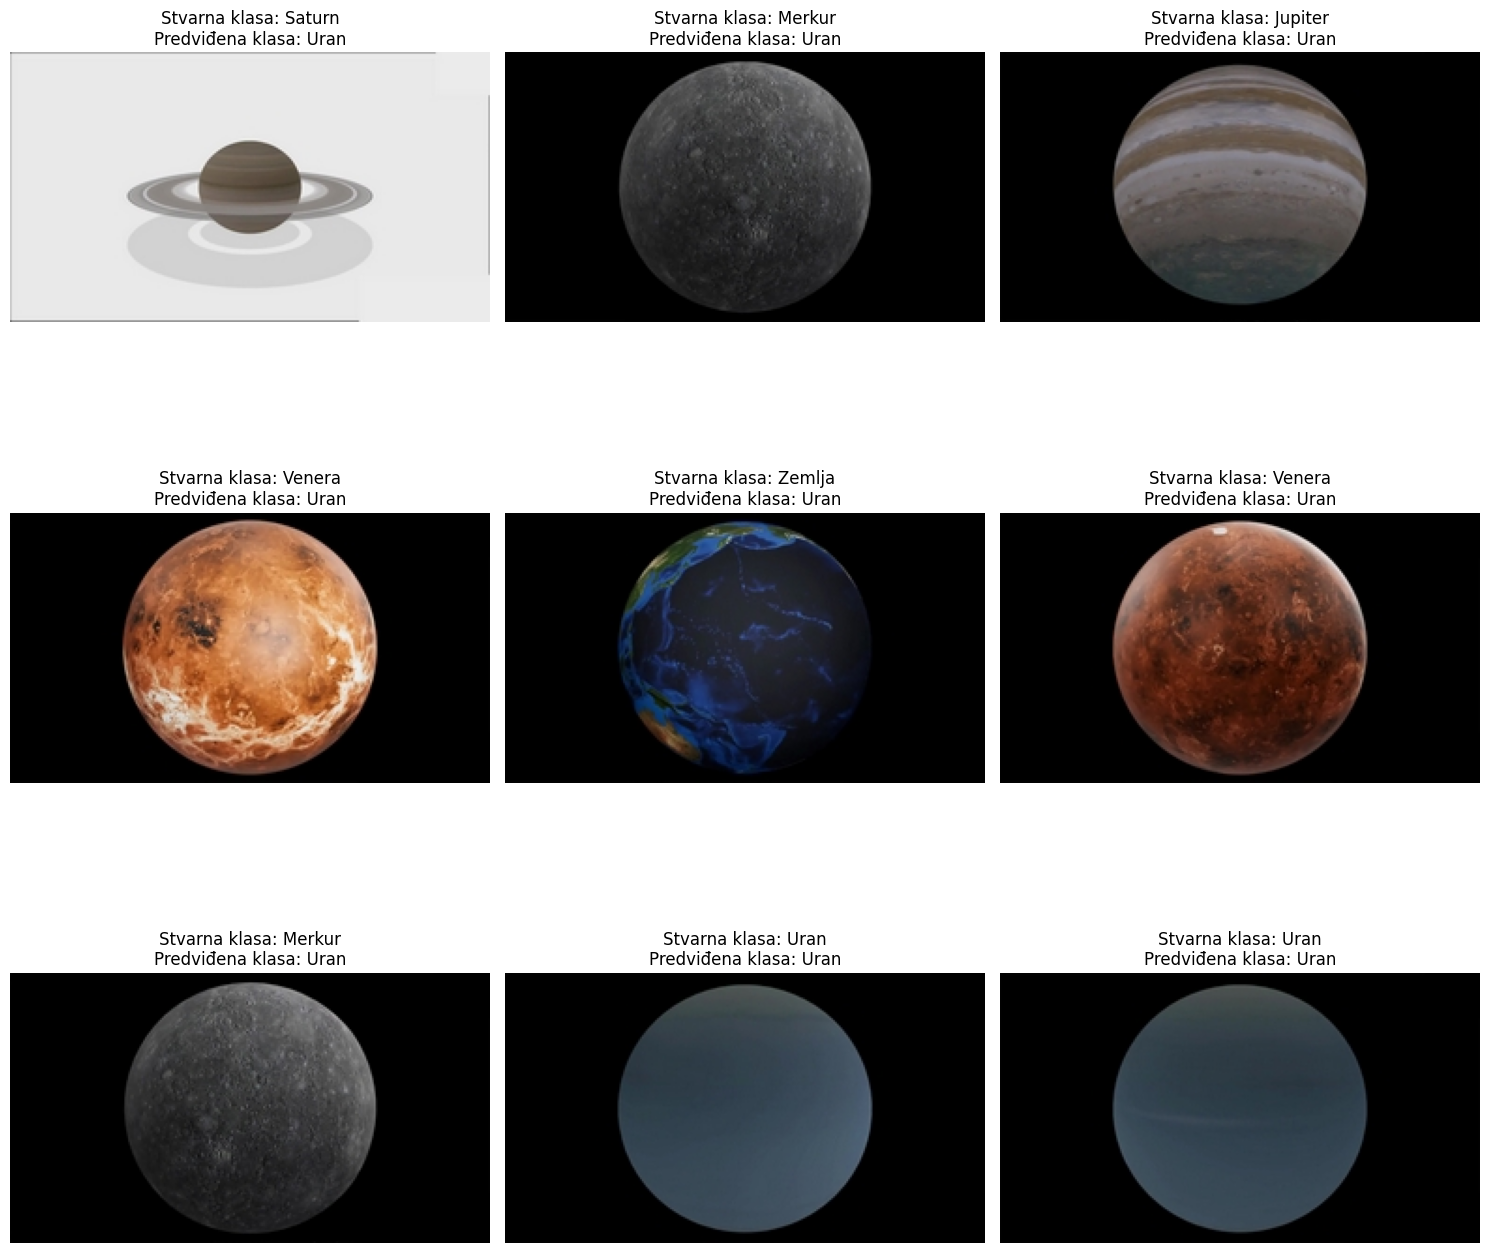

In [25]:
from tensorflow.keras.preprocessing import image 
# Dobijanje random 9 putanja iz test generatora
putanje = np.random.choice(putanje_slika, 9, replace=False)

# Prikazivanje slika sa random putanja
plt.figure(figsize=(15, 15))
for i, putanja in enumerate(putanje):
    
    # Učitavanje slike
    slika = plt.imread(putanja)

    # Učitavanje slike sa putanje
    img = image.load_img(putanja, target_size=(256,256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Normalizacija slike 
    x = x / 255.0  # Normalizacija piksela na [0, 1] opseg
    
    # Predviđanje klase
    predikcija = model.predict(x)
    
    # Pretvaranje predikcije u čitljiv oblik
    klasa_predikcije = planete[np.argmax(predikcija)]
    
    # Dobijanje oznake klase iz putanje
    klasa = putanja.split('/')[-2]  # Pretpostavka da je klasa pretposlednji deo putanje
    
    # Prikaz slike
    plt.subplot(3, 3, i + 1)
    plt.imshow(slika)
    plt.title(f"Stvarna klasa: {klasa}\nPredviđena klasa: {klasa_predikcije}")
    plt.axis('off')

plt.tight_layout()
plt.show()



    

# Analiza modela na skupu planeta, bez veštački generisanih slika

- U toku treniranja, model se pokazao izuzetno dobro.
- Na validacionom skupu je takođe veoma brzo, već posle 10 epoha, dostigao apsolutnu preciznost, uz zanemarljiv gubitak
- Performanse modela na test skupu, međutim, daleko su lošije, sa preciznošću od oko 85%, što je očigledan znak da se model preprilagodio

Može se pokušati da se prevaziđe u drugom delu ovog projekta - proširenjem skupa slika.

# ---------------------------------------------------------------------------------------------------

## Sateliti

Baza slika korišćena za treniranje i evaluaciju modela za klasifikaciju satelita je ručno napravljena skidanjem slika sa zvaničnog Nasinog sajta i preko Google Images.  
Pojedini sateliti, na primer, Uranovi i Neptunovi sateliti, su toliko daleko od Zemlje da nisu postojale brojne ekspedicije koje su ih istraživale, i malobrojne dostupne slike su mutne i neupotrebljive za analizu, pa nisu uzete u razmatranje.  
Baza se sastoji iz sledećih satelita:

Zemlja
 - Mesec  

Mars
 - Fobos (*Phobos*)
 - Deimos

Jupiter
  - Kalisto (*Callisto*)
  - Evropa  (*Europa*)
  - Ganimed (*Ganymede*)
  - Io

Saturn
  - Enkelad (*Enceladus*)
  - Mimant (*Mimas*)
  - Reja (*Rhea*)
  - Titan


Isti postupak će biti primenjen i u ovom delu projekta, sa manje detaljisanja.

In [13]:
def planeta_kojoj_pripada(satelit):
    if satelit == 'Mesec':
        return 'Zemlja'
    elif satelit == 'Fobos' or satelit == 'Deimos':
        return 'Mars'
    elif satelit == 'Kalisto' or satelit == 'Evropa' or satelit == 'Ganimed' or satelit == 'Io':
        return 'Jupiter'
    else:
        return 'Saturn'


### Učitavanje baze

In [14]:
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input


data_dir = 'sateliti'

maticne_planete = ['Jupiter','Mars','Saturn','Zemlja']

# Lista satelita
sateliti = ['Evropa', 'Ganimed', 'Io', 'Kalisto', 'Deimos', 'Fobos', 'Enkelad','Mimant','Reja','Titan', 'Mesec']

slike_niz = []  # Bice korisceno za treniranje i evaluaciju modela
slike_putanje = [] # Bice korisceno za prikaz slika iz test skupa
oznake = []
j = 0;

# Popunjavanje slika iz svakog poddirektorijuma
# Svaka kategorija ce biti numerička, označena brojevima 0-10
for i, planeta in enumerate(maticne_planete):
    planeta_dir = os.path.join(data_dir, planeta)
    lista_satelita = os.listdir(planeta_dir)
    for satelit in lista_satelita:
        satelit_dir = os.path.join(planeta_dir,satelit)
        slike = os.listdir(satelit_dir)
        for slika in slike:
            slika_putanja = os.path.join(satelit_dir, slika)
            img = image.load_img(slika_putanja, target_size=(256,256))
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)
            slike_niz.append(img_array)
            slike_putanje.append(slika_putanja)
            oznake.append(j)
        j = j+1
        
        


### Podela na test, trening i validacioni skup

In [15]:
from sklearn.model_selection import train_test_split

# Statifikovana podela na test i trening skup, 70% trening, 30% test
X_train, X_test, y_train, y_test = train_test_split(slike_niz, oznake, test_size=0.3, stratify=oznake, random_state=42)
# Podela ostatak dataset-a na validacioni (10%) i test (20%) skup
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, stratify=y_test, random_state=42)


In [16]:
print("Broj slika u trening skupu:", len(X_train))
print("Broj slika u validacionom skupu:", len(X_val))
print("Broj slika u test skupu:", len(X_test))

Broj slika u trening skupu: 344
Broj slika u validacionom skupu: 49
Broj slika u test skupu: 99


### Treniranje i evaluacija

Konvertovanjem podataka u NumPy nizove se osigurava da su oni u odgovarajućem formatu za dalju obradu u Kerasu ili drugim bibliotekama za mašinsko učenje. Ovo je posebno važno kada se koristi Keras, jer njegove funkcije i metode očekuju da ulazni podaci budu u formi NumPy nizova radi pravilnog funkcionisanja.

Epoch 1/10
11/11 [==============================] - 18s 2s/step - loss: 3.4163 - accuracy: 0.2238 - val_loss: 2.2088 - val_accuracy: 0.3061
Epoch 2/10
11/11 [==============================] - 17s 2s/step - loss: 1.9936 - accuracy: 0.3779 - val_loss: 2.4815 - val_accuracy: 0.3061
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 1.6742 - accuracy: 0.4419 - val_loss: 2.2164 - val_accuracy: 0.3061
Epoch 4/10
11/11 [==============================] - 17s 2s/step - loss: 1.4115 - accuracy: 0.5349 - val_loss: 2.3633 - val_accuracy: 0.3265
Epoch 5/10
11/11 [==============================] - 16s 1s/step - loss: 1.1431 - accuracy: 0.5988 - val_loss: 2.2814 - val_accuracy: 0.3265
Epoch 6/10
11/11 [==============================] - 16s 1s/step - loss: 0.9877 - accuracy: 0.6773 - val_loss: 2.0765 - val_accuracy: 0.4082
Epoch 7/10
11/11 [==============================] - 17s 2s/step - loss: 0.8312 - accuracy: 0.7326 - val_loss: 2.2803 - val_accuracy: 0.4286
Epoch 8/10
11/11 [==

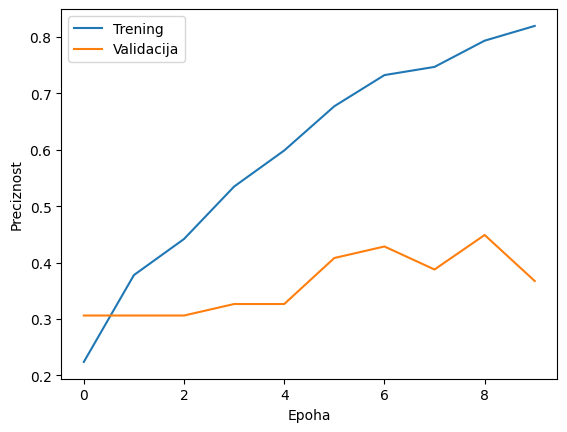

In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Treniranje modela
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Prikazivanje grafika tačnosti
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Validacija')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()
plt.show()


Ponovo, model se preprilagodio, a preciznost na validacionom skupu nije rasla.

### Evaluacija modela u klasifikaciji satelita

4/4 [==============================] - 1s 189ms/step


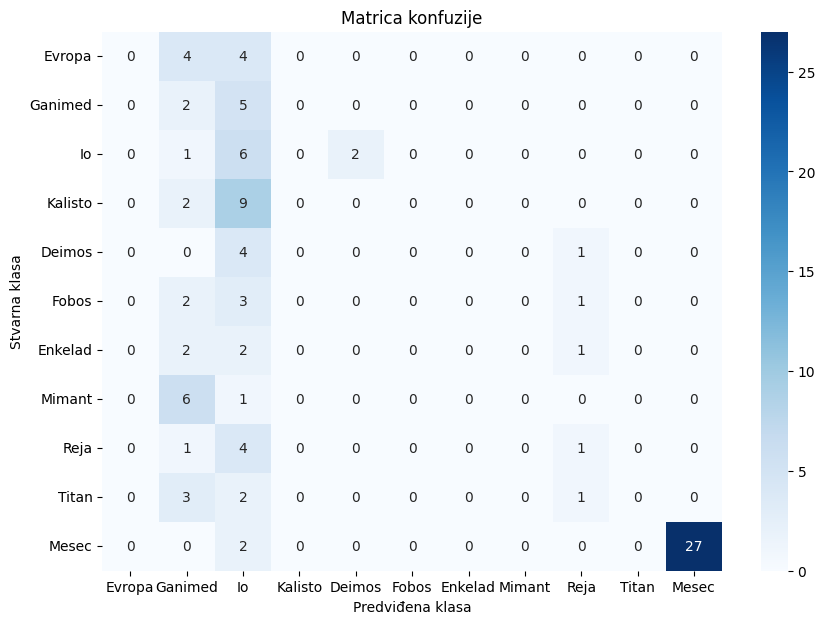

4/4 [==============================] - 1s 163ms/step - loss: 2.8621 - accuracy: 0.3636
Preciznost na test skupu: 0.3636363744735718
Gubitak na test skupu: 2.862147092819214


In [18]:
predikcije = np.argmax(model.predict(np.array(X_test)), axis=-1)

# Stvarne vrednosti za test skup
stvarno = np.array(y_test)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=sateliti, columns=sateliti)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()

# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(np.array(X_test), np.array(y_test))
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)


Model je imao najviše uspeha u tačnom predviđanju Meseca. 
Preciznost na test skupu je mala, a gubitak je veliki, što znači da model nema dobru moć generalizacije nad ovim skupom. 

### Prvi pokušaj optimizacije

Klase su poprilično nebalansirane, što se može videti na sledećem grafiku.

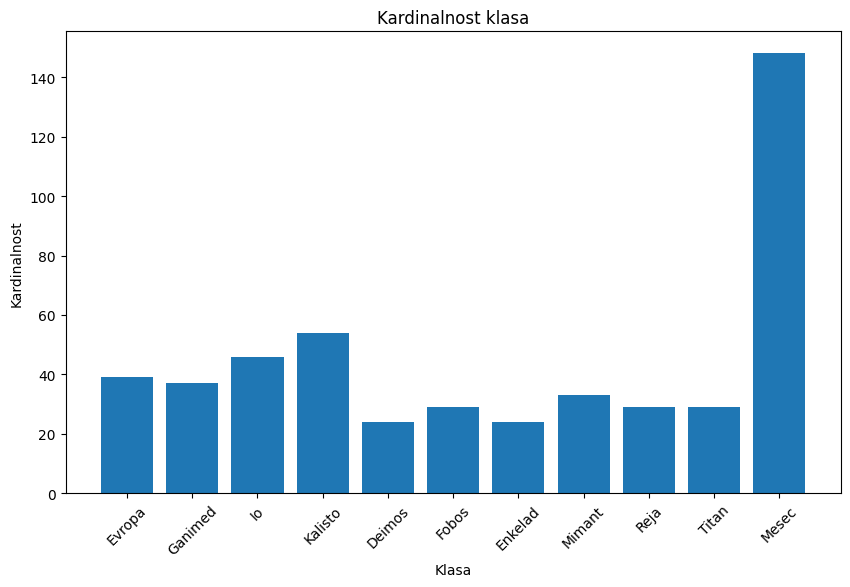

In [19]:
import matplotlib.pyplot as plt

# Izračunavanje kardinalnosti klasa
kardinalnosti = {}
for oznaka in oznake:
    if oznaka in kardinalnosti:
        kardinalnosti[oznaka] += 1
    else:
        kardinalnosti[oznaka] = 1

# Priprema podataka za grafik
labels = [f"{sateliti[klasa]}" for klasa in kardinalnosti.keys()]
values = list(kardinalnosti.values())

# Crtanje grafika
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Klasa')
plt.ylabel('Kardinalnost')
plt.title('Kardinalnost klasa')
plt.xticks(rotation=45)
plt.show()



Da li će balansiranje klasa i uvođenje težina pomoći u optimizaciji modela?

**Napomena**: Ovaj metod nije primenjen kod klasifikacije planeta jer su sve klase balansirane sa tačno 149 slika u svakoj, pa se u tom slučaju moraju iskoristiti drugi vidovi optimizacije.

### Klasne težine

Argument *class_weight='balanced'* označava da se koristi "balansirana" težina za klase, što znači da će manje zastupljene klase imati veću težinu, a više zastupljene klase manju težinu. Funkcija uzima jedinstvene vrednosti iz niza oznake kao *classes* argument, koji predstavlja klase koje treba balansirati, dok *y=oznake* predstavlja sam niz oznaka koje se koriste za izračunavanje težina. Na kraju, funkcija vraća niz težina za svaku klasu, koji se može koristiti u modelu za obučavanje.

In [20]:
from sklearn.utils import class_weight

# Izračunanje težine za klase
tezine = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(oznake), y=oznake)

# Pretvaranje težine u rečnik koji se može koristiti u modelu
tezine_dict = dict(enumerate(tezine))


Epoch 1/10
11/11 [==============================] - 17s 2s/step - loss: 0.8554 - accuracy: 0.7878 - val_loss: 2.4168 - val_accuracy: 0.2653
Epoch 2/10
11/11 [==============================] - 17s 2s/step - loss: 0.6313 - accuracy: 0.8517 - val_loss: 2.3578 - val_accuracy: 0.3469
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 0.5062 - accuracy: 0.8750 - val_loss: 1.9114 - val_accuracy: 0.4694
Epoch 4/10
11/11 [==============================] - 17s 2s/step - loss: 0.4293 - accuracy: 0.9012 - val_loss: 1.9161 - val_accuracy: 0.4490
Epoch 5/10
11/11 [==============================] - 17s 2s/step - loss: 0.2956 - accuracy: 0.9360 - val_loss: 2.0233 - val_accuracy: 0.4490
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 0.2705 - accuracy: 0.9360 - val_loss: 2.7088 - val_accuracy: 0.4082
Epoch 7/10
11/11 [==============================] - 17s 2s/step - loss: 0.3580 - accuracy: 0.8866 - val_loss: 2.3318 - val_accuracy: 0.4490
Epoch 8/10
11/11 [==

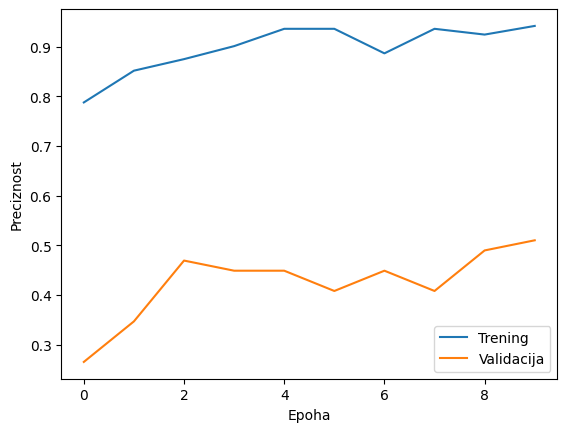

4/4 [==============================] - 1s 205ms/step - loss: 2.2277 - accuracy: 0.4444
Preciznost na test skupu: 0.4444444477558136
Gubitak na test skupu: 2.2276813983917236


In [21]:
# Treniranje modela
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, class_weight=tezine_dict)

# Prikazivanje grafika tačnosti
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Validacija')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()
plt.show()

# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(np.array(X_test), np.array(y_test))
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

Da li je model imao poboljšanje posle ove modifikacije će kazati matrica konfuzije.

4/4 [==============================] - 1s 202ms/step


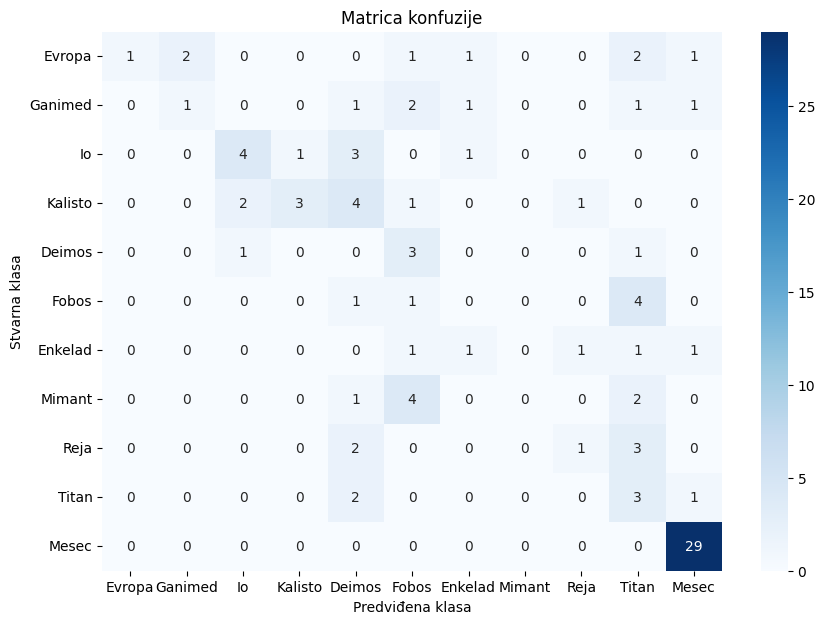

4/4 [==============================] - 1s 213ms/step - loss: 2.2277 - accuracy: 0.4444
Preciznost na test skupu: 0.4444444477558136
Gubitak na test skupu: 2.2276813983917236


In [22]:
predikcije = np.argmax(model.predict(np.array(X_test)), axis=-1)

# Stvarne vrednosti za test skup
stvarno = np.array(y_test)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=sateliti, columns=sateliti)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()

# Evaluacija modela na test skupu
gubitak, preciznost = model.evaluate(np.array(X_test), np.array(y_test))
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)


Ovaj metod optimizacije nije ispunio očekivanja.

### Upotreba modela u klasifikaciji satelita

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


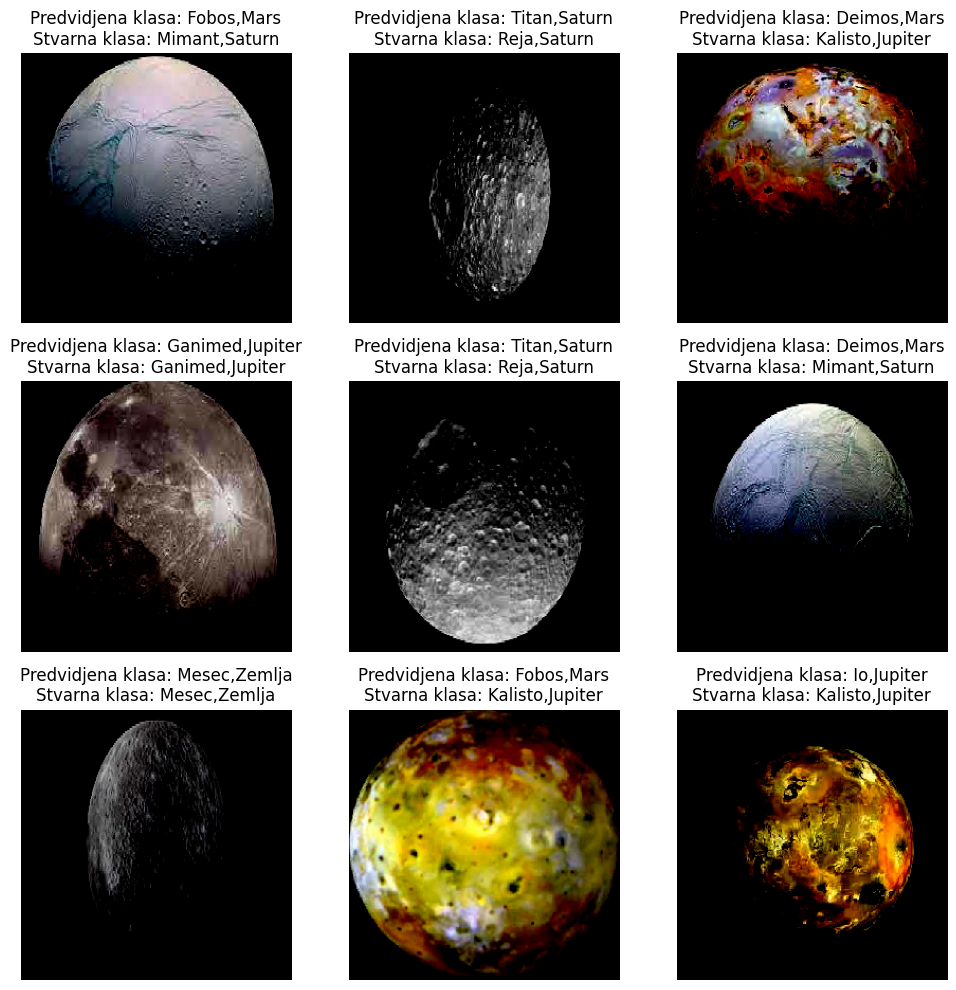

In [23]:
import matplotlib.pyplot as plt
# Prikazuje 3x3 matricu slika sa predviđenim i stvarnim klasama
def prikazi_matricu_slika(slike, predvidjene_klase, stvarne_klase):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(slike[i])
        satelit_ime = sateliti[predvidjene_klase[i]]
        planeta_satelita = planeta_kojoj_pripada(satelit_ime)
        plt.title(f'Predvidjena klasa: {satelit_ime},{planeta_satelita}\nStvarna klasa: {sateliti[stvarne_klase[i]]},{planeta_kojoj_pripada(sateliti[stvarne_klase[i]])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Prikazuje matricu 3x3 primera iz test skupa
broj_prikaza = 9
indeksi = np.random.choice(range(len(X_test)), broj_prikaza, replace=False)
slike_prikaz = [X_test[idx] for idx in indeksi]
predvidjene_klase = [np.argmax(model.predict(np.expand_dims(slika, axis=0))) for slika in slike_prikaz]
stvarne_klase = [y_test[idx] for idx in indeksi]

prikazi_matricu_slika(slike_prikaz, predvidjene_klase, stvarne_klase)


Ovaj vid optimizacije nije dao zadovoljavajuće rezultate i još uvek je sklon davanju prednosti jednoj klasi, i takođe se preprilagodio - gubitak je veliki.    
Poboljšanje se može videti u povećanju sposobnosti razlikovanja satelita Io i Zemljinog Meseca.  
U sledećem delu, biće prikazan drugi mogući način prevazilaženja ovog problema.